In [54]:
#import dependencies
import os
import requests
import json 
from dotenv import load_dotenv
load_dotenv()
from binance.client import Client
import pandas as pd
from finta import TA
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import confusion_matrix,classification_report
import hvplot.pandas
from sklearn.cluster import KMeans
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

In [2]:

#api keys
API_KEY = os.getenv("BINANCE_API_KEY")

API_SECRET = os.getenv("BINANCE_SECRET_KEY")
#create api object
client = Client(API_KEY,API_SECRET, tld='us')

candles = client.get_historical_klines("ETHUSDT", Client.KLINE_INTERVAL_1DAY, "1 Dec, 2016", "1 Dec, 2022")

#set list to hold candle data
open = []
high = []
low = []
close = []
volume = []
time=[]

#for loop that adds data to lists above
for i in range(len(candles)):
    open.append(candles[i][1])
    high.append(candles[i][2])
    low.append(candles[i][3])
    close.append(candles[i][4])
    volume.append(candles[i][5])
    time.append(candles[i][6])

#create df for each set of data
candle_df_open = pd.DataFrame(open, columns= ['open'])
candle_df_high = pd.DataFrame(high, columns= ['high'])
candle_df_low = pd.DataFrame(low, columns= ['low'])
candle_df_close = pd.DataFrame(close, columns= ['close'])
candle_df_volume = pd.DataFrame(volume, columns= ['volume'])
candle_df_time = pd.DataFrame(time, columns= ['time'])

#concatenate data into single df
candle_df = pd.concat([candle_df_open,candle_df_high,candle_df_low,candle_df_close,candle_df_volume, candle_df_time], axis =1)

#fix time, set index, and cast as float
candle_df['time'] = pd.to_datetime(candle_df['time'], unit='ms')
candle_df = candle_df.set_index('time')
candle_df = candle_df.astype('float')


# *Justin's Stategy:*

In [3]:
#create df for close and actual returns
signals_df = candle_df.loc[:,['close']]

signals_df['actual returns'] = signals_df['close'].pct_change()

signals_df = signals_df.dropna()

display(signals_df.head())
display(signals_df.tail())

,close,actual returns
time,,
2019-09-24 23:59:59.999,167.09,-0.202625
2019-09-25 23:59:59.999,170.00,0.017416
2019-09-26 23:59:59.999,166.69,-0.019471
2019-09-27 23:59:59.999,173.69,0.041994
2019-09-28 23:59:59.999,172.84,-0.004894


,close,actual returns
time,,
2022-11-27 23:59:59.999,1193.83,-0.009204
2022-11-28 23:59:59.999,1168.13,-0.021527
2022-11-29 23:59:59.999,1216.37,0.041297
2022-11-30 23:59:59.999,1293.60,0.063492
2022-12-01 23:59:59.999,1276.50,-0.013219


In [4]:
#create AO tech analysis
signals_df['AO'] = TA.AO(candle_df)

In [5]:
# Initialize the new Signal column
signals_df['Signal'] = 0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
signals_df.loc[(signals_df['AO'] > 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
signals_df.loc[(signals_df['AO'] < 0) , 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,actual returns,AO,Signal
time,,,,
2019-09-24 23:59:59.999,167.09,-0.202625,NaN,0
2019-09-25 23:59:59.999,170.00,0.017416,NaN,0
2019-09-26 23:59:59.999,166.69,-0.019471,NaN,0
2019-09-27 23:59:59.999,173.69,0.041994,NaN,0
2019-09-28 23:59:59.999,172.84,-0.004894,NaN,0


,close,actual returns,AO,Signal
time,,,,
2022-11-27 23:59:59.999,1193.83,-0.009204,-168.887294,-1
2022-11-28 23:59:59.999,1168.13,-0.021527,-158.246000,-1
2022-11-29 23:59:59.999,1216.37,0.041297,-149.849882,-1
2022-11-30 23:59:59.999,1293.60,0.063492,-127.099618,-1
2022-12-01 23:59:59.999,1276.50,-0.013219,-106.833353,-1


In [6]:
#calc strategy returns
signals_df['Strategy Returns'] = signals_df['actual returns'] * signals_df['Signal'].shift().dropna()

<AxesSubplot:xlabel='time'>

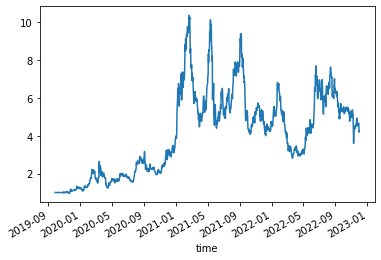

In [7]:
#plot returns
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [8]:
#seperate features from labels
X = signals_df[['AO']].shift().dropna()

y = signals_df['Signal']

# Review the value counts
y.value_counts()

 1    623
-1    510
 0     32
Name: Signal, dtype: int64

In [9]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2019-10-27 23:59:59.999000


In [10]:
#set training data date
training_end = X.index.min() + DateOffset(months=12)

# Display the training end date
print(training_end)

2020-10-27 23:59:59.999000


In [11]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,AO
time,
2019-10-27 23:59:59.999,-5.545735
2019-10-28 23:59:59.999,-2.792618
2019-10-29 23:59:59.999,1.387824
2019-10-30 23:59:59.999,6.068676
2019-10-31 23:59:59.999,7.756059


In [13]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(months=6):]
y_test = y.loc[training_end+DateOffset(months=6):]

# Review the X_test DataFrame
X_test.head()

,AO
time,
2021-04-27 23:59:59.999,256.077824
2021-04-28 23:59:59.999,255.078235
2021-04-29 23:59:59.999,301.228853
2021-04-30 23:59:59.999,363.549500
2021-05-01 23:59:59.999,432.439853


In [14]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [15]:
# From SVM, instantiate SVC classifier model instance
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
 
# Fit the model to the data using the training data
lr_model = lr_model.fit(X_train_scaled,y_train)
 
# Use the testing data to make the model predictions
lr_pred = lr_model.predict(X_test_scaled)

# Review the model's predicted values
lr_pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1, -1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1, -1, -1, -1, -1

In [16]:
#classification report
lr_testing_report = classification_report(y_test, lr_pred)

# Print the classification report
print(lr_testing_report)

              precision    recall  f1-score   support

          -1       0.97      0.96      0.97       358
           1       0.94      0.96      0.95       226

    accuracy                           0.96       584
   macro avg       0.96      0.96      0.96       584
weighted avg       0.96      0.96      0.96       584



In [17]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = lr_pred

# Add the actual returns to the DataFrame
predictions_df['actual returns'] = signals_df['actual returns']

# Add the strategy returns to the DataFrame
predictions_df['Trading Algo Returns'] = signals_df['actual returns'] * predictions_df['Predicted'].shift()

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,actual returns,Trading Algo Returns
time,,,
2021-04-27 23:59:59.999,1,0.052279,NaN
2021-04-28 23:59:59.999,1,0.030482,0.030482
2021-04-29 23:59:59.999,1,0.003662,0.003662
2021-04-30 23:59:59.999,1,0.005962,0.005962
2021-05-01 23:59:59.999,1,0.061800,0.061800


,Predicted,actual returns,Trading Algo Returns
time,,,
2022-11-27 23:59:59.999,-1,-0.009204,0.009204
2022-11-28 23:59:59.999,-1,-0.021527,0.021527
2022-11-29 23:59:59.999,-1,0.041297,-0.041297
2022-11-30 23:59:59.999,-1,0.063492,-0.063492
2022-12-01 23:59:59.999,-1,-0.013219,0.013219


<AxesSubplot:xlabel='time'>

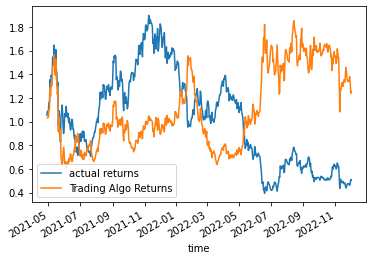

In [18]:
#plot actual returns vs strategy returns using ML
(1 + predictions_df[["actual returns", "Trading Algo Returns"]]).cumprod().plot()

# *Alpha's Stategy:*

In [21]:
signals_df = candle_df.loc[:,['close','volume']]

signals_df['actual returns'] = signals_df['close'].pct_change()

signals_df = signals_df


display(signals_df.head())
display(signals_df.tail())

,close,volume,actual returns
time,,,
2019-09-23 23:59:59.999,209.55,0.01000,NaN
2019-09-24 23:59:59.999,167.09,2224.36708,-0.202625
2019-09-25 23:59:59.999,170.00,181.60286,0.017416
2019-09-26 23:59:59.999,166.69,545.45350,-0.019471
2019-09-27 23:59:59.999,173.69,630.91688,0.041994


,close,volume,actual returns
time,,,
2022-11-27 23:59:59.999,1193.83,654.26480,-0.009204
2022-11-28 23:59:59.999,1168.13,1260.68583,-0.021527
2022-11-29 23:59:59.999,1216.37,1504.19549,0.041297
2022-11-30 23:59:59.999,1293.60,2191.94037,0.063492
2022-12-01 23:59:59.999,1276.50,623.48889,-0.013219


In [24]:
signals_df = signals_df.dropna()

In [25]:
# Create a a list to store inertia values and the values of k
inertia = []
k = list(range(1, 11))

In [26]:
# Create a for-loop where each value of k is evaluated using the K-means algorithm
# Fit the model using the service_ratings DataFrame
# Append the value of the computed inertia from the `inertia_` attribute of the KMeans model instance
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(signals_df)
    inertia.append(k_model.inertia_)

c:\Users\Justin\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  "KMeans is known to have a memory leak on Windows "


In [27]:
# Define a DataFrame to hold the values for k and the corresponding inertia
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)

# Review the DataFrame
df_elbow.head()

,k,inertia
0,1,3.225763e+10
1,2,1.145190e+10
2,3,6.311233e+09
3,4,4.420940e+09
4,5,3.191162e+09


In [28]:
# Plot the DataFrame
df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

:Curve   [k]   (inertia)

In [29]:
# Define the model with 4 clusters
model = KMeans(n_clusters=3, random_state=1)

# Fit the model
model.fit(signals_df)

# Make predictions
k_3 = model.predict(signals_df)

# Create a copy of the DataFrame
signals_df_predictions = signals_df.copy()

# Add a class column with the labels
signals_df_predictions['cluster_segment'] = k_3

In [30]:
# Plot the clusters
signals_df_predictions.hvplot.scatter(
    x="close",
    y="volume",
    by="cluster_segment"
)

:NdOverlay   [cluster_segment]
   :Scatter   [close]   (volume)

In [31]:
signals_df.describe()

,close,volume,actual returns
count,1165.000000,1165.000000,1165.000000
mean,1571.279545,4556.943578,0.002892
std,1304.340115,5100.141170,0.051042
min,108.650000,79.553530,-0.441359
25%,259.150000,1300.655520,-0.021185
50%,1356.250000,2702.626210,0.002174
75%,2606.520000,5736.375100,0.028991
max,4809.610000,34393.012140,0.263013


In [32]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

#generate signal to buy stock
signals_df.loc[(signals_df['actual returns'] <= -0.021), 'Signal'] = 1

#generate signal to sell stock
signals_df.loc[(signals_df['actual returns'] >= 0.028), 'Signal'] = -1

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

c:\Users\Justin\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\Justin\anaconda3\envs\dev\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,close,volume,actual returns,Signal
time,,,,
2019-09-24 23:59:59.999,167.09,2224.36708,-0.202625,1.0
2019-09-25 23:59:59.999,170.00,181.60286,0.017416,0.0
2019-09-26 23:59:59.999,166.69,545.45350,-0.019471,0.0
2019-09-27 23:59:59.999,173.69,630.91688,0.041994,-1.0
2019-09-28 23:59:59.999,172.84,158.67273,-0.004894,0.0


,close,volume,actual returns,Signal
time,,,,
2022-11-27 23:59:59.999,1193.83,654.26480,-0.009204,0.0
2022-11-28 23:59:59.999,1168.13,1260.68583,-0.021527,1.0
2022-11-29 23:59:59.999,1216.37,1504.19549,0.041297,-1.0
2022-11-30 23:59:59.999,1293.60,2191.94037,0.063492,-1.0
2022-12-01 23:59:59.999,1276.50,623.48889,-0.013219,0.0


In [33]:
signals_df['Signal'].value_counts()

 0.0    570
-1.0    301
 1.0    294
Name: Signal, dtype: int64

In [34]:
signals_df['strategy returns'] = signals_df['actual returns'] * signals_df['Signal'].shift()

display(signals_df.head())
display(signals_df.tail())

c:\Users\Justin\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,close,volume,actual returns,Signal,strategy returns
time,,,,,
2019-09-24 23:59:59.999,167.09,2224.36708,-0.202625,1.0,NaN
2019-09-25 23:59:59.999,170.00,181.60286,0.017416,0.0,0.017416
2019-09-26 23:59:59.999,166.69,545.45350,-0.019471,0.0,-0.000000
2019-09-27 23:59:59.999,173.69,630.91688,0.041994,-1.0,0.000000
2019-09-28 23:59:59.999,172.84,158.67273,-0.004894,0.0,0.004894


,close,volume,actual returns,Signal,strategy returns
time,,,,,
2022-11-27 23:59:59.999,1193.83,654.26480,-0.009204,0.0,-0.000000
2022-11-28 23:59:59.999,1168.13,1260.68583,-0.021527,1.0,-0.000000
2022-11-29 23:59:59.999,1216.37,1504.19549,0.041297,-1.0,0.041297
2022-11-30 23:59:59.999,1293.60,2191.94037,0.063492,-1.0,-0.063492
2022-12-01 23:59:59.999,1276.50,623.48889,-0.013219,0.0,0.013219


In [35]:
signals_df = signals_df.dropna()
signals_df

,close,volume,actual returns,Signal,strategy returns
time,,,,,
2019-09-25 23:59:59.999,170.00,181.60286,0.017416,0.0,0.017416
2019-09-26 23:59:59.999,166.69,545.45350,-0.019471,0.0,-0.000000
2019-09-27 23:59:59.999,173.69,630.91688,0.041994,-1.0,0.000000
2019-09-28 23:59:59.999,172.84,158.67273,-0.004894,0.0,0.004894
2019-09-29 23:59:59.999,169.46,1365.66487,-0.019556,0.0,-0.000000
...,...,...,...,...,...
2022-11-27 23:59:59.999,1193.83,654.26480,-0.009204,0.0,-0.000000
2022-11-28 23:59:59.999,1168.13,1260.68583,-0.021527,1.0,-0.000000
2022-11-29 23:59:59.999,1216.37,1504.19549,0.041297,-1.0,0.041297


In [36]:
# Visualize entry position relative to close price
entry = signals_df[signals_df['Signal'] == 1.0]['close'].hvplot.scatter(
    color='yellow',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize exit position relative to close price
exit = signals_df[signals_df['Signal'] == -1.0]['close'].hvplot.scatter(
    color='purple',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df[['close']].hvplot(
    line_color='red',
    ylabel='Price in $',
    width=1000,
    height=400
)

# Create the overlay plot
entry_exit_plot = security_close  * entry * exit

# Show the plot with a title
entry_exit_plot.opts(
    title="ETH , Entry and Exit Points"
)

:Overlay
   .Curve.I          :Curve   [time]   (close)
   .Scatter.Close.I  :Scatter   [time]   (close)
   .Scatter.Close.II :Scatter   [time]   (close)

In [37]:
## Set initial capital
initial_capital = float(200000)

# Set the share size
share_size = 500

# Buy a 500 share position when the Signal equals 1
# Otherwise, `Position` should be -1 (sell)
signals_df['Position'] = share_size * signals_df['Signal']

# Determine the points in time where a 500 share position is bought or sold
signals_df['Entry/Exit Position'] = signals_df['Position'].diff()

# Multiply the close price by the number of shares held, or the Position
signals_df['Portfolio Holdings'] = signals_df['close'] * signals_df['Position']

# Subtract the amount of either the cost or proceeds of the trade from the initial capital invested
signals_df['Portfolio Cash'] = initial_capital - (signals_df['close'] * signals_df['Entry/Exit Position']).cumsum() 

# Calculate the total portfolio value by adding the portfolio cash to the portfolio holdings (or investments)
signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + signals_df['Portfolio Holdings']

# Calculate the portfolio daily returns
signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()

# Calculate the portfolio cumulative returns
signals_df['Portfolio Cumulative Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1

In [38]:
display(signals_df.head())
display(signals_df.tail())

,close,volume,actual returns,Signal,strategy returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
time,,,,,,,,,,,,
2019-09-25 23:59:59.999,170.00,181.60286,0.017416,0.0,0.017416,0.0,NaN,0.0,NaN,NaN,NaN,NaN
2019-09-26 23:59:59.999,166.69,545.45350,-0.019471,0.0,-0.000000,0.0,0.0,0.0,200000.0,200000.0,NaN,NaN
2019-09-27 23:59:59.999,173.69,630.91688,0.041994,-1.0,0.000000,-500.0,-500.0,-86845.0,286845.0,200000.0,0.000000,0.000000
2019-09-28 23:59:59.999,172.84,158.67273,-0.004894,0.0,0.004894,0.0,500.0,0.0,200425.0,200425.0,0.002125,0.002125
2019-09-29 23:59:59.999,169.46,1365.66487,-0.019556,0.0,-0.000000,0.0,0.0,0.0,200425.0,200425.0,0.000000,0.002125


,close,volume,actual returns,Signal,strategy returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
time,,,,,,,,,,,,
2022-11-27 23:59:59.999,1193.83,654.26480,-0.009204,0.0,-0.000000,0.0,0.0,0.0,2678005.0,2678005.0,0.000000,12.390025
2022-11-28 23:59:59.999,1168.13,1260.68583,-0.021527,1.0,-0.000000,500.0,500.0,584065.0,2093940.0,2678005.0,0.000000,12.390025
2022-11-29 23:59:59.999,1216.37,1504.19549,0.041297,-1.0,0.041297,-500.0,-1000.0,-608185.0,3310310.0,2702125.0,0.009007,12.510625
2022-11-30 23:59:59.999,1293.60,2191.94037,0.063492,-1.0,-0.063492,-500.0,0.0,-646800.0,3310310.0,2663510.0,-0.014291,12.317550
2022-12-01 23:59:59.999,1276.50,623.48889,-0.013219,0.0,0.013219,0.0,500.0,0.0,2672060.0,2672060.0,0.003210,12.360300


In [39]:
# Visualize exit position relative to total portfolio value
exit = signals_df[signals_df['Signal'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='yellow',
    marker='v',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = signals_df[signals_df['Signal'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='purple',
    marker='^',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize the value of the total portfolio
total_portfolio_value = signals_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    xlabel='Date',
    width=1000,
    height=400
)

# Overlay the plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="ETH Algorithm - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [time]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [time]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [time]   (Portfolio Total)

In [40]:
# Create a list for the column name
columns = ["Backtest"]

# Create a list holding the names of the new evaluation metrics
metrics = [
    "Annualized Return",
    "Cumulative Returns",
    "Annual Volatility",
    "Sharpe Ratio",
    "Sortino Ratio"]

# Initialize the DataFrame with index set to the evaluation metrics and the column
eth_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

# Review the DataFrame
eth_evaluation_df

,Backtest
Annualized Return,NaN
Cumulative Returns,NaN
Annual Volatility,NaN
Sharpe Ratio,NaN
Sortino Ratio,NaN


In [42]:
## Calculate the Metrics

# Calculate annualized return
eth_evaluation_df.loc["Annualized Return"] = (
    signals_df["Portfolio Daily Returns"].mean() * 252
)

# Calculate cumulative return
eth_evaluation_df.loc["Cumulative Returns"] = signals_df["Portfolio Cumulative Returns"][-1]

# Calculate annual volatility
eth_evaluation_df.loc["Annual Volatility"] = (
    signals_df["Portfolio Daily Returns"].std() * np.sqrt(252)
)

# Calculate Sharpe ratio
eth_evaluation_df.loc["Sharpe Ratio"] = (
    signals_df["Portfolio Daily Returns"].mean() * 252) / (
    signals_df["Portfolio Daily Returns"].std() * np.sqrt(252)
)

# Review the result
eth_evaluation_df

,Backtest
Annualized Return,6.842591
Cumulative Returns,12.3603
Annual Volatility,11.669041
Sharpe Ratio,0.586388
Sortino Ratio,NaN


In [43]:
### Sortino Ratio

#### Calculate downside return values

# Create a DataFrame that contains the Portfolio Daily Returns column
sortino_ratio_df = signals_df[["Portfolio Daily Returns"]].copy()

# Create a column to hold downside return values
sortino_ratio_df.loc[:,"Downside Returns"] = 0

# Find Portfolio Daily Returns values less than 0,
# square those values, and add them to the Downside Returns column
sortino_ratio_df.loc[sortino_ratio_df["Portfolio Daily Returns"] < 0,
                     "Downside Returns"] = sortino_ratio_df["Portfolio Daily Returns"]**2

# Review the DataFrame
sortino_ratio_df.tail()

,Portfolio Daily Returns,Downside Returns
time,,
2022-11-27 23:59:59.999,0.000000,0.000000
2022-11-28 23:59:59.999,0.000000,0.000000
2022-11-29 23:59:59.999,0.009007,0.000000
2022-11-30 23:59:59.999,-0.014291,0.000204
2022-12-01 23:59:59.999,0.003210,0.000000


In [44]:
#### Calculate the Sortino ratio

# Calculate the annualized return value
annualized_return = (
    sortino_ratio_df["Portfolio Daily Returns"].mean() * 252
)

# Calculate the annualized downside standard deviation value
downside_standard_deviation = (
    np.sqrt(sortino_ratio_df["Downside Returns"].mean()) * np.sqrt(252)
)

# The Sortino ratio is reached by dividing the annualized return value
# by the downside standard deviation value
sortino_ratio = annualized_return/downside_standard_deviation

# Add the Sortino ratio to the evaluation DataFrame
eth_evaluation_df.loc["Sortino Ratio"] = sortino_ratio

# Review the DataFrame
eth_evaluation_df

,Backtest
Annualized Return,6.842591
Cumulative Returns,12.3603
Annual Volatility,11.669041
Sharpe Ratio,0.586388
Sortino Ratio,8.539741


In [46]:
# Assign a copy of the `close`, `volume`, 'actual returns'  columns to a new DataFrame called `X`
X = signals_df[['close','volume','actual returns']].copy()

# Display sample data
display(X.head())
display(X.tail())

,close,volume,actual returns
time,,,
2019-09-25 23:59:59.999,170.00,181.60286,0.017416
2019-09-26 23:59:59.999,166.69,545.45350,-0.019471
2019-09-27 23:59:59.999,173.69,630.91688,0.041994
2019-09-28 23:59:59.999,172.84,158.67273,-0.004894
2019-09-29 23:59:59.999,169.46,1365.66487,-0.019556


,close,volume,actual returns
time,,,
2022-11-27 23:59:59.999,1193.83,654.26480,-0.009204
2022-11-28 23:59:59.999,1168.13,1260.68583,-0.021527
2022-11-29 23:59:59.999,1216.37,1504.19549,0.041297
2022-11-30 23:59:59.999,1293.60,2191.94037,0.063492
2022-12-01 23:59:59.999,1276.50,623.48889,-0.013219


In [47]:
# Create a target in the `signals_df` called 'y'
y =signals_df['Signal']
y[:5]

time
2019-09-25 23:59:59.999    0.0
2019-09-26 23:59:59.999    0.0
2019-09-27 23:59:59.999   -1.0
2019-09-28 23:59:59.999    0.0
2019-09-29 23:59:59.999    0.0
Name: Signal, dtype: float64

In [48]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

2019-09-25 23:59:59.999000


In [49]:
# Select the ending period for the training data with an offset of 24 months
training_end = X.loc[:'2021-09-25']

# Display the training end date
training_end.tail()

,close,volume,actual returns
time,,,
2021-09-21 23:59:59.999,2766.36,9907.44258,-0.070522
2021-09-22 23:59:59.999,3078.05,4639.17703,0.112672
2021-09-23 23:59:59.999,3154.00,6488.59090,0.024675
2021-09-24 23:59:59.999,2926.01,5141.00830,-0.072286
2021-09-25 23:59:59.999,2923.84,9074.79561,-0.000742


In [50]:
# Generate the X_train and y_train DataFrames
X_train = training_end
y_train = y.loc[:'2021-09-25']

#X_train.tail()
y_train.tail()

time
2021-09-21 23:59:59.999    1.0
2021-09-22 23:59:59.999   -1.0
2021-09-23 23:59:59.999    0.0
2021-09-24 23:59:59.999    1.0
2021-09-25 23:59:59.999    0.0
Name: Signal, dtype: float64

In [51]:
# Generate the X_test and y_test DataFrames
X_test = X.loc['2021-09-26':]
y_test = y.loc['2021-09-26':]

X_test.tail()
y_test.tail()

time
2022-11-27 23:59:59.999    0.0
2022-11-28 23:59:59.999    1.0
2022-11-29 23:59:59.999   -1.0
2022-11-30 23:59:59.999   -1.0
2022-12-01 23:59:59.999    0.0
Name: Signal, dtype: float64

In [52]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the Standard Scaler with the features 'X' data
X_scaler = scaler.fit(X_train)

# Scale the features 'X' data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a Logistic Regression Model 
lr_model = LogisticRegression(solver='lbfgs', random_state=1)

lr_model.fit(X_train_scaled, y_train)

# Predict outcomes for test data set
lr_pred = lr_model.predict(X_test_scaled)

In [53]:
lr_testing_report = classification_report(y_test, lr_pred)

# Print the classification report
print(lr_testing_report)

              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99        94
         0.0       0.92      1.00      0.96       219
         1.0       1.00      0.85      0.92       119

    accuracy                           0.96       432
   macro avg       0.97      0.95      0.96       432
weighted avg       0.96      0.96      0.96       432



In [55]:
dtree_model = tree.DecisionTreeClassifier()

# Fitting the model
dtree_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
dtree_pred = dtree_model.predict(X_test_scaled)

# Displaying classification report
print(classification_report(y_test, dtree_pred))

              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        94
         0.0       1.00      0.99      0.99       219
         1.0       0.99      1.00      1.00       119

    accuracy                           0.99       432
   macro avg       0.99      1.00      0.99       432
weighted avg       0.99      0.99      0.99       432



In [56]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fit the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
rf_pred = rf_model.predict(X_test_scaled)

# Displaying classification report
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

        -1.0       0.98      1.00      0.99        94
         0.0       0.99      0.99      0.99       219
         1.0       1.00      0.97      0.99       119

    accuracy                           0.99       432
   macro avg       0.99      0.99      0.99       432
weighted avg       0.99      0.99      0.99       432



# *Dmitry's Stategy:*

In [58]:
# Filter the date index and close columns
signals_df = candle_df.loc[:, ["close"]]

# Use the pct_change function to generate returns from close prices
signals_df["Actual Returns"] = signals_df["close"].pct_change()

# Drop all NaN 
signals_df = signals_df.dropna()

# Review 
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns
time,,
2019-09-24 23:59:59.999,167.09,-0.202625
2019-09-25 23:59:59.999,170.00,0.017416
2019-09-26 23:59:59.999,166.69,-0.019471
2019-09-27 23:59:59.999,173.69,0.041994
2019-09-28 23:59:59.999,172.84,-0.004894


,close,Actual Returns
time,,
2022-11-27 23:59:59.999,1193.83,-0.009204
2022-11-28 23:59:59.999,1168.13,-0.021527
2022-11-29 23:59:59.999,1216.37,0.041297
2022-11-30 23:59:59.999,1293.60,0.063492
2022-12-01 23:59:59.999,1276.50,-0.013219


In [59]:
# Set the short window and long window
short_window = 4
long_window = 200

# Generate the fast and slow simple moving averages
signals_df['SMA_Fast'] = signals_df['close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['close'].rolling(window=long_window).mean()
signals_df = signals_df.dropna()

# Review 
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow
time,,,,
2020-04-10 23:59:59.999,157.40,-0.075260,166.2875,172.24000
2020-04-11 23:59:59.999,158.41,0.006417,164.7200,172.19660
2020-04-12 23:59:59.999,158.72,0.001957,161.1850,172.14020
2020-04-13 23:59:59.999,156.47,-0.014176,157.7500,172.08910
2020-04-14 23:59:59.999,157.50,0.006583,157.7750,172.00815


,close,Actual Returns,SMA_Fast,SMA_Slow
time,,,,
2022-11-27 23:59:59.999,1193.83,-0.009204,1200.1325,1487.88700
2022-11-28 23:59:59.999,1168.13,-0.021527,1191.4100,1483.93515
2022-11-29 23:59:59.999,1216.37,0.041297,1195.8125,1479.98445
2022-11-30 23:59:59.999,1293.60,0.063492,1217.9825,1476.17395
2022-12-01 23:59:59.999,1276.50,-0.013219,1238.6500,1471.82645


In [60]:
# Initialize the new Signal column
signals_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy long
signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell short
signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

# Review 
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
time,,,,,
2020-04-10 23:59:59.999,157.40,-0.075260,166.2875,172.24000,-1.0
2020-04-11 23:59:59.999,158.41,0.006417,164.7200,172.19660,1.0
2020-04-12 23:59:59.999,158.72,0.001957,161.1850,172.14020,1.0
2020-04-13 23:59:59.999,156.47,-0.014176,157.7500,172.08910,-1.0
2020-04-14 23:59:59.999,157.50,0.006583,157.7750,172.00815,1.0


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal
time,,,,,
2022-11-27 23:59:59.999,1193.83,-0.009204,1200.1325,1487.88700,-1.0
2022-11-28 23:59:59.999,1168.13,-0.021527,1191.4100,1483.93515,-1.0
2022-11-29 23:59:59.999,1216.37,0.041297,1195.8125,1479.98445,1.0
2022-11-30 23:59:59.999,1293.60,0.063492,1217.9825,1476.17395,1.0
2022-12-01 23:59:59.999,1276.50,-0.013219,1238.6500,1471.82645,-1.0


In [61]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
time,,,,,,
2020-04-10 23:59:59.999,157.40,-0.075260,166.2875,172.24000,-1.0,NaN
2020-04-11 23:59:59.999,158.41,0.006417,164.7200,172.19660,1.0,-0.006417
2020-04-12 23:59:59.999,158.72,0.001957,161.1850,172.14020,1.0,0.001957
2020-04-13 23:59:59.999,156.47,-0.014176,157.7500,172.08910,-1.0,-0.014176
2020-04-14 23:59:59.999,157.50,0.006583,157.7750,172.00815,1.0,-0.006583


,close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
time,,,,,,
2022-11-27 23:59:59.999,1193.83,-0.009204,1200.1325,1487.88700,-1.0,-0.009204
2022-11-28 23:59:59.999,1168.13,-0.021527,1191.4100,1483.93515,-1.0,0.021527
2022-11-29 23:59:59.999,1216.37,0.041297,1195.8125,1479.98445,1.0,-0.041297
2022-11-30 23:59:59.999,1293.60,0.063492,1217.9825,1476.17395,1.0,0.063492
2022-12-01 23:59:59.999,1276.50,-0.013219,1238.6500,1471.82645,-1.0,-0.013219


<AxesSubplot:xlabel='time'>

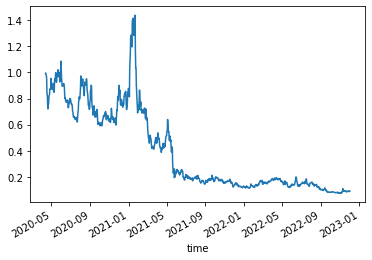

In [62]:
# Plot Strategy Returns
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [63]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

,SMA_Fast,SMA_Slow
time,,
2020-04-11 23:59:59.999,166.2875,172.24000
2020-04-12 23:59:59.999,164.7200,172.19660
2020-04-13 23:59:59.999,161.1850,172.14020
2020-04-14 23:59:59.999,157.7500,172.08910
2020-04-15 23:59:59.999,157.7750,172.00815


In [64]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal']

# Review 
y.value_counts()

 1.0    512
-1.0    454
Name: Signal, dtype: int64

In [65]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

# Select the ending period for the training data with an offset of 30 months
training_end = X.index.min() + DateOffset(months=30)

# Display the training end date
print(training_end)

2020-04-11 23:59:59.999000
2022-10-11 23:59:59.999000


In [66]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()

,SMA_Fast,SMA_Slow
time,,
2020-04-11 23:59:59.999,166.2875,172.24000
2020-04-12 23:59:59.999,164.7200,172.19660
2020-04-13 23:59:59.999,161.1850,172.14020
2020-04-14 23:59:59.999,157.7500,172.08910
2020-04-15 23:59:59.999,157.7750,172.00815


In [67]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
X_test.head()

,SMA_Fast,SMA_Slow
time,,
2022-10-12 23:59:59.999,1302.1250,1879.04485
2022-10-13 23:59:59.999,1296.9650,1869.77900
2022-10-14 23:59:59.999,1288.2725,1859.73145
2022-10-15 23:59:59.999,1290.0725,1849.56375
2022-10-16 23:59:59.999,1288.5400,1838.92860


In [68]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [69]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
svm_pred

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [70]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)

# Print the classification report
print (svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.43      0.23      0.30        26
         1.0       0.46      0.68      0.55        25

    accuracy                           0.45        51
   macro avg       0.44      0.46      0.42        51
weighted avg       0.44      0.45      0.42        51



In [71]:
# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)

# Add the SVM model predictions to the DataFrame
predictions_df['Predicted'] = svm_pred
# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = signals_df['Strategy Returns']

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

,Predicted,Actual Returns,Strategy Returns
time,,,
2022-10-12 23:59:59.999,-1.0,0.010975,-0.010975
2022-10-13 23:59:59.999,-1.0,-0.004883,-0.004883
2022-10-14 23:59:59.999,-1.0,0.007811,-0.007811
2022-10-15 23:59:59.999,-1.0,-0.018429,-0.018429
2022-10-16 23:59:59.999,-1.0,0.025768,-0.025768


,Predicted,Actual Returns,Strategy Returns
time,,,
2022-11-27 23:59:59.999,1.0,-0.009204,-0.009204
2022-11-28 23:59:59.999,1.0,-0.021527,0.021527
2022-11-29 23:59:59.999,1.0,0.041297,-0.041297
2022-11-30 23:59:59.999,1.0,0.063492,0.063492
2022-12-01 23:59:59.999,1.0,-0.013219,-0.013219


<AxesSubplot:xlabel='time'>

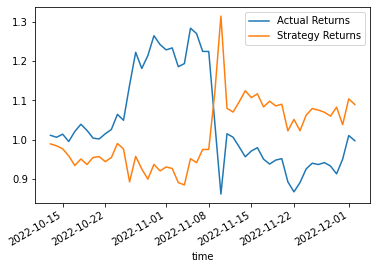

In [72]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()

# *Ravi's Strategy*